## Imports

In [17]:
# Standard library imports
import os
import random
import warnings
import json

# Data processing and numerical operations
import pandas as pd
import numpy as np
from datasets import load_dataset  # Dataset handling

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline
from collections import defaultdict

# Deep learning frameworks
import torch as pt

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Checking for GPU availability
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU Name: {pt.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


## Data Loading and EDA

### Dataset
 Overview 
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.  

SQuAD 1.1 contains 100,000+ question-answer pairs on 500+ articles.  


**Dataset Structure**  
An example of 'train' looks as follows.

    {  
        "answers": {  
            "answer_start": [1],  
            "text": ["This is a test text"]  
        },  
        "context": "This is a test context.",  
        "id": "1",  
        "question": "Is this a test?",  
        "title": "train test"  
    }  


**plain_text**
- id: a string feature.
- title: a string feature.
- context: a string feature.
- question: a string feature.
- answers: a dictionary feature containing:
    - text: a string feature.
    - answer_start: a int32 feature.

In [5]:
squad_dataset = load_dataset('squad')

train_data = squad_dataset['train']
validation_data = squad_dataset['validation']

print(f'Train data size: {len(train_data)}')
print(f'Validation data size: {len(validation_data)}')

print(train_data.column_names)

c:\Users\pawan\anaconda3\envs\AAI520\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pawan\.cache\huggingface\hub\datasets--squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating validation split: 100%|██████████| 10570/10570 [00:00<00:00, 367129.24 examples/s]


Train data size: 87599
Validation data size: 10570
['id', 'title', 'context', 'question', 'answers']


Lets look at an example entry to see what we are dealing with

In [6]:
example = json.dumps(train_data[0], indent=4)
print(example)

{
    "id": "5733be284776f41900661182",
    "title": "University_of_Notre_Dame",
    "context": "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",
    "question": "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?",
    "answers": {
        "text": [
            "Saint Bernadette Soubirous"
        ],
        "answer_start": [

### Exploratory Data Analysis

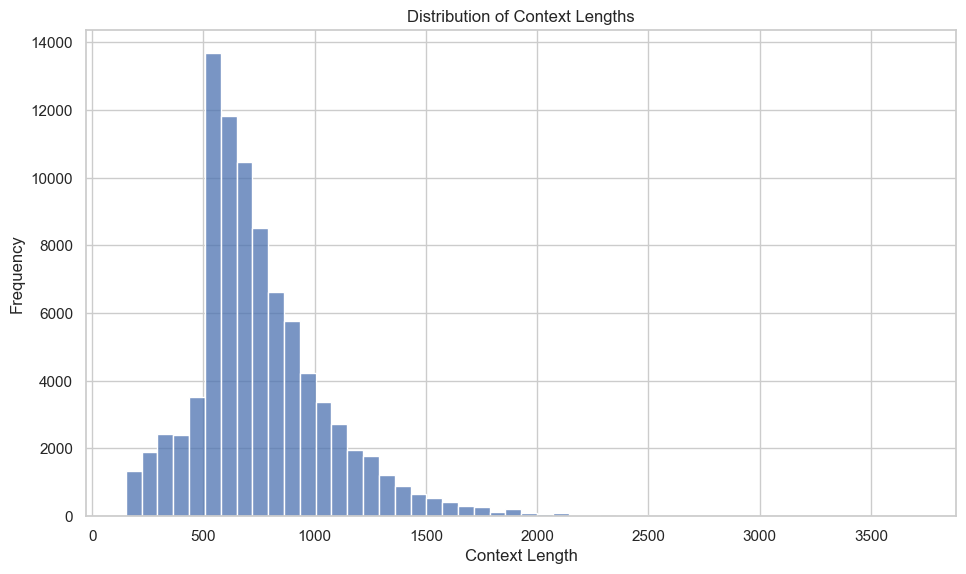

In [5]:
context_lengths = [len(ex['context']) for ex in train_data]
plt.figure(figsize=(10,6))
sns.histplot(context_lengths, bins=50)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.show()

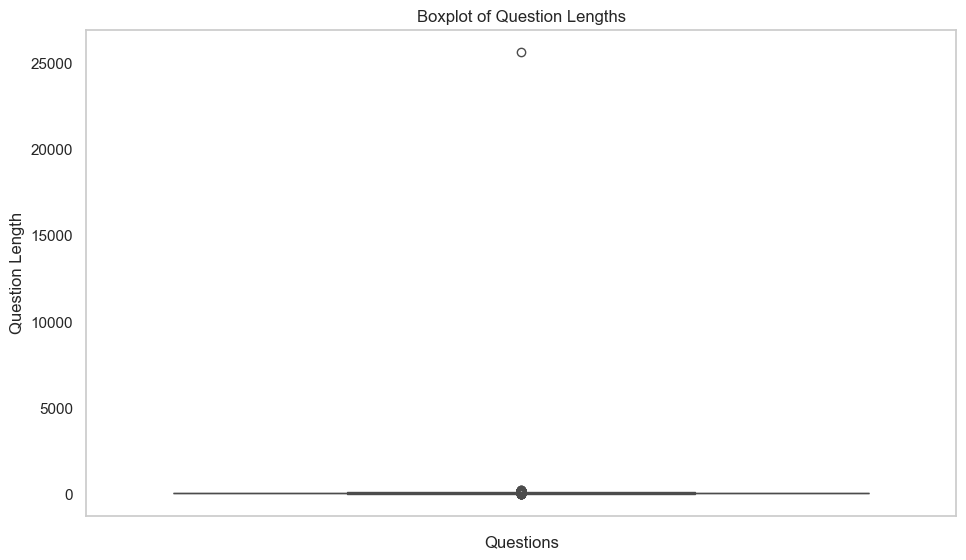

Max question length: 25651
Min question length: 1
Mean question length: 59.57113665681115


In [8]:
question_lengths = [len(sample['question']) for sample in train_data]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=question_lengths)
plt.title('Boxplot of Question Lengths')
plt.ylabel('Question Length')
plt.xlabel('Questions')
plt.grid(axis='y')
plt.show()

print(f"Max question length: {max(question_lengths)}")
print(f"Min question length: {min(question_lengths)}")
print(f"Mean question length: {np.mean(question_lengths)}")

The boxplot shows a very clear outliet `max question length` above. Let's invesigate this.

In [10]:
long_questions_with_indices = [(idx, sample) for idx, sample in enumerate(train_data) if len(sample['question']) > 1000]
print(f"Number of questions longer than 1000 characters: {len(long_questions_with_indices)}")

for index, long_question in long_questions_with_indices[:5]:
    print(f"Index: {index}, Question: {long_question['question']} (Length: {len(long_question['question'])})")

Number of questions longer than 1000 characters: 1
Index: 75237, Question:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

The question is mostly whitespace. We will remove the question. We can also trim it but we chose to remove this singular entry for convenience.

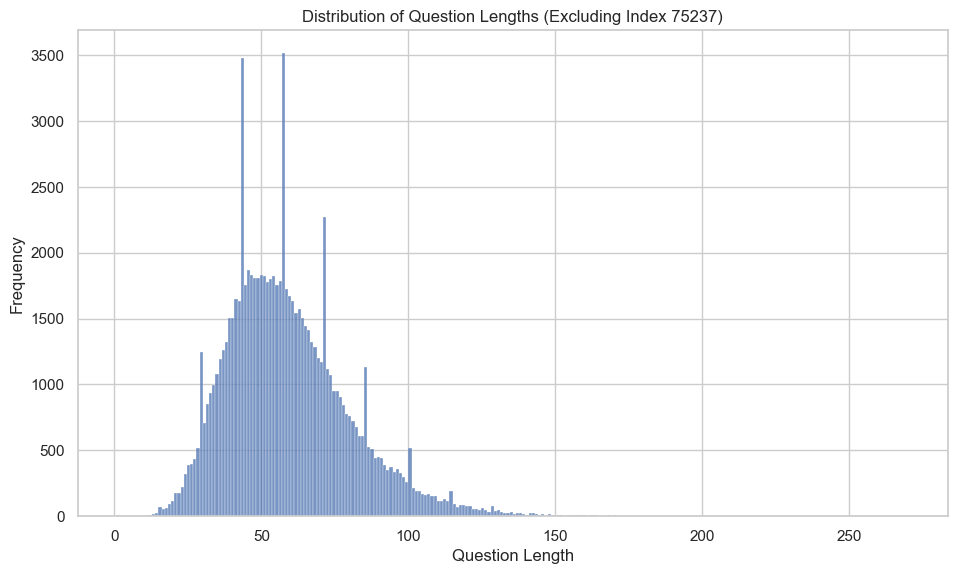

In [11]:
# Exclude the question at index 75237
filtered_data = [sample for idx, sample in enumerate(train_data) if idx != 75237]

question_lengths = [len(sample['question']) for sample in filtered_data]

plt.figure(figsize=(10, 6))
sns.histplot(question_lengths, bins=250)
plt.title('Distribution of Question Lengths (Excluding Index 75237)')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

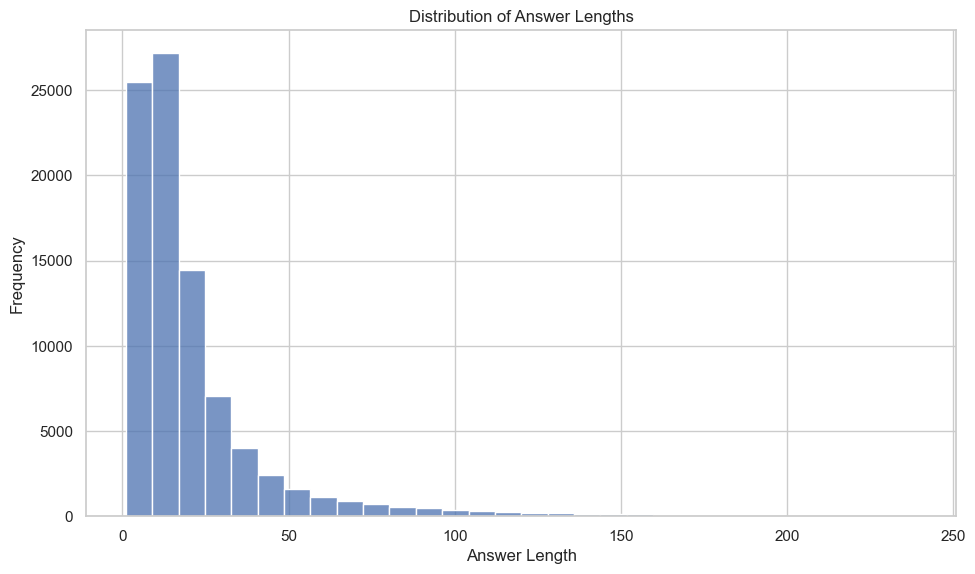

In [12]:
answer_lengths = [len(sample['answers']['text'][0]) for sample in train_data]
plt.figure(figsize=(10,6))
sns.histplot(answer_lengths, bins=30)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Function to print entries

def print_entries(dataset, num_entries=1):
    num_entries = min(num_entries, len(dataset))

    for index in range(num_entries):
        data = dataset[index]

        print(f"Entry {index + 1}:\n")
        print(f"ID: {data['id']}")
        print(f"Title: {data['title']}")
        print(f"Context: {data['context']}")
        print(f"Question: {data['question']}")
        print(f"Answers: {data['answers']['text']}")
        print("\n")

print_entries(train_data, 5) 

Entry 1:

ID: 5733be284776f41900661182
Title: University_of_Notre_Dame
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answers: ['Saint Bernadette Soubirous']


Entry 2:

ID: 5733be284776f4190066117f
Title: University_of_Notre_Dame
Context: Architecturally, the

In [15]:
# Print number of titles and contexts in the data

unique_titles = train_data.unique('title')
print(f"Number of unique titles in train data: {len(unique_titles)}")

unique_context = train_data.unique('context')
print(f'Number of unique "context" in train data: {len(unique_context)}')

Number of unique titles in train data: 442
Number of unique "context" in train data: 18891


Taking this a step further, lets see how many "contexts" belong to each "title" and then how many questions belong to each unique context.

In [18]:
title_context_question_count = defaultdict(lambda: {"contexts": set(), "total_questions": 0})

# iterate through data
for entry in train_data:
    title = entry['title']
    context = entry['context']
    title_context_question_count[title]["contexts"].add(context)
    title_context_question_count[title]["total_questions"] += 1

# creating a PrettyTable object
table = PrettyTable(["Title", "# of Contexts", "# of Questions"])

# populating the table
for title, counts in title_context_question_count.items():
    table.add_row([title, len(counts['contexts']), counts['total_questions']])

print(table)

+-------------------------------------------------------------+---------------+----------------+
|                            Title                            | # of Contexts | # of Questions |
+-------------------------------------------------------------+---------------+----------------+
|                   University_of_Notre_Dame                  |       55      |      269       |
|                           Beyoncé                           |       66      |      758       |
|                           Montana                           |       44      |      150       |
|                           Genocide                          |       26      |      137       |
|                         Antibiotics                         |       26      |      169       |
|                       Frédéric_Chopin                       |       82      |      697       |
|        Sino-Tibetan_relations_during_the_Ming_dynasty       |       72      |      291       |
|                             

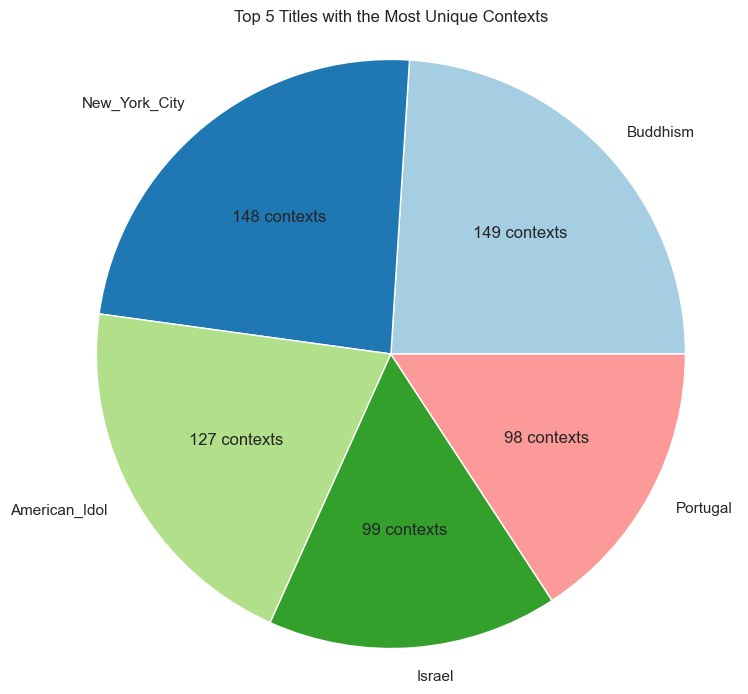

In [19]:
# Step 1: Aggregate data - Count unique contexts for each title
title_context_count = defaultdict(set)

for entry in train_data:
    title = entry['title']
    context = entry['context']
    title_context_count[title].add(context)

# Step 2: Convert the set of contexts into counts
title_context_count = {title: len(contexts) for title, contexts in title_context_count.items()}

# Step 3: Sort the titles by the number of contexts (descending order)
sorted_titles = sorted(title_context_count.items(), key=lambda x: x[1], reverse=True)

# Step 4: Prepare data for the pie chart (limiting to top N titles, e.g., top 10)
top_n = 5
top_titles = [title for title, count in sorted_titles[:top_n]]
top_context_counts = [count for title, count in sorted_titles[:top_n]]

# Step 5: Define a function to show number of contexts instead of percentage
def make_autopct(context_counts):
    def autopct(pct):
        total = sum(context_counts)
        val = int(round(pct * total / 100.0))
        return f'{val} contexts'
    return autopct

# Step 6: Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_context_counts, labels=top_titles, autopct=make_autopct(top_context_counts), startangle=0, colors=plt.cm.Paired.colors)
plt.title(f'Top {top_n} Titles with the Most Unique Contexts')
plt.axis('equal')
plt.show()

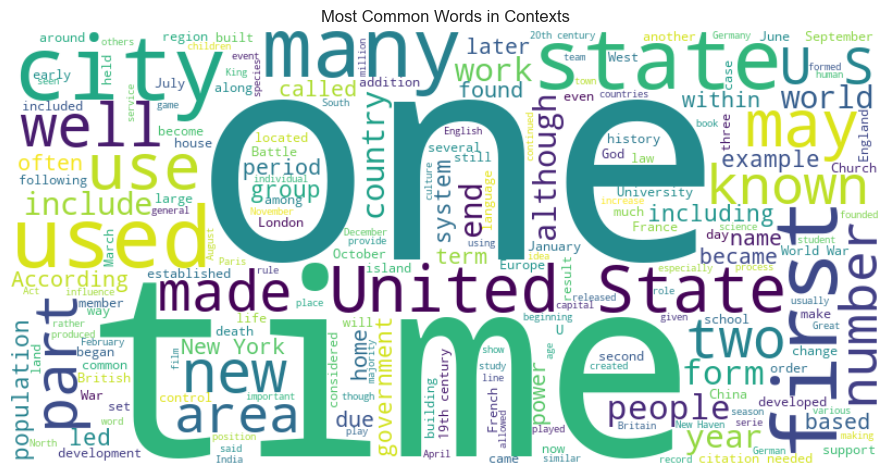

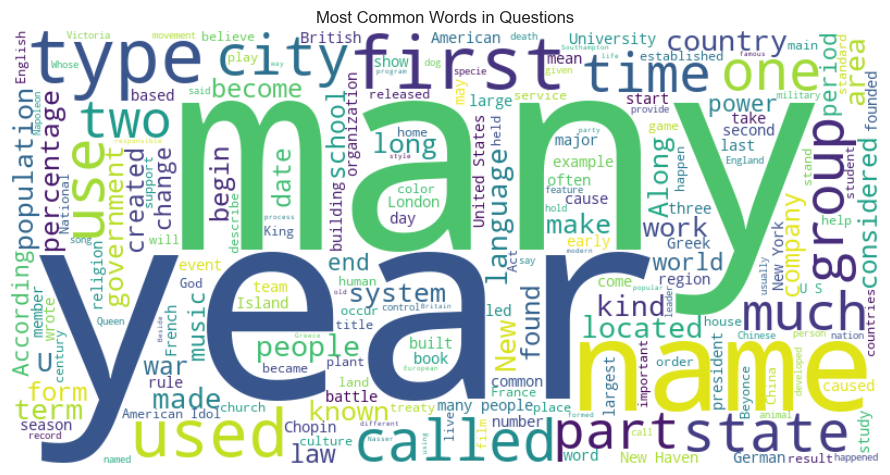

In [21]:
from wordcloud import WordCloud

# Most common words in contexts
all_contexts = ' '.join([ex['context'] for ex in train_data])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_contexts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Contexts')
plt.show()

# Most common words in questions
all_questions = ' '.join([ex['question'] for ex in train_data])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_questions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Questions')
plt.show()

In [16]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, AutoTokenizer

# distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Below method borrowed from the following resource: [HuggingFace QuestionAnswering Documentation --> Preprocess](https://huggingface.co/docs/transformers/en/tasks/question_answering#preprocess)

In [17]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = distilbert_tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [18]:
tokenized_squad_train = train_data.map(preprocess_function, batched=True, remove_columns=train_data.column_names)
tokenized_squad_validation = validation_data.map(preprocess_function, batched=True, remove_columns=validation_data.column_names)

Speeding up training time, here are 3 optimizations I used:
fp16 --> mixed precision training to speed up computations  
increased batch size --> went from 16 to 32 to push my GPU harder since utilization was low (if you get an OutOfMemory Error, decrease batch size)  
increased dataloader workers

In [19]:
from transformers import DefaultDataCollator, TrainingArguments, Trainer

data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_squad_train,
    eval_dataset=tokenized_squad_validation,
    tokenizer=distilbert_tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.545500,1.419541
2,1.079300,1.314202
3,0.558100,1.500396


TrainOutput(global_step=16425, training_loss=1.1593492974175348, metrics={'train_runtime': 2221.5645, 'train_samples_per_second': 118.294, 'train_steps_per_second': 7.393, 'total_flos': 2.575143204683213e+16, 'train_loss': 1.1593492974175348, 'epoch': 3.0})

Down below when trying to perform inference, I was getting a ValueError so I am re-saving the model to correct it.

In [20]:
distilbert_model.save_pretrained("my_awesome_qa_model")
distilbert_tokenizer.save_pretrained("my_awesome_qa_model")

('my_awesome_qa_model\\tokenizer_config.json',
 'my_awesome_qa_model\\special_tokens_map.json',
 'my_awesome_qa_model\\vocab.txt',
 'my_awesome_qa_model\\added_tokens.json',
 'my_awesome_qa_model\\tokenizer.json')

In [21]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [22]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="my_awesome_qa_model", device=device)
question_answerer(question=question, context=context)

{'score': 0.9620850086212158, 'start': 93, 'end': 95, 'answer': '13'}